In [1]:
import numpy as np
# 訓練データと検証データの分割
from sklearn.model_selection import train_test_split
# 予測結果の精度確認（ROC曲線の描画）
from sklearn.metrics import roc_auc_score, roc_curve
# データを扱う
import pandas as pd
# グラフ描画
from matplotlib import pyplot as plt

In [2]:
import torch
# 自動微分の関数 
from torch.autograd import Variable
# ニューラルネットワークの関数
import torch.nn as nn
# 活性化関数
import torch.nn.functional as F
# 最適化のアルゴリズムの関数
import torch.optim as optim
#ユーティリティのデータから
from torch.utils.data import DataLoader ,TensorDataset

## 訓練データの読み込み

In [3]:
# CSVファイル読み込み（訓練データ）
df_train = pd.read_csv('train.csv')
df_train.head()

,Age,Gender,T_Bil,D_Bil,ALP,ALT_GPT,AST_GOT,TP,Alb,AG_ratio,disease
0,59,Male,0.786886,0.150498,220.178691,13.467617,21.729246,6.815731,3.112276,1.006802,0
1,69,Male,1.003987,0.195625,221.218413,51.033462,64.752323,6.889608,3.051521,0.751346,1
2,65,Male,0.657140,0.081287,320.770533,12.625011,30.613180,5.947767,2.489167,0.774952,0
3,65,Male,0.906822,0.214173,369.278160,34.347597,54.510085,6.967183,3.613837,0.988155,1
4,22,Female,1.734959,0.197706,222.782025,20.572891,170.010177,5.837537,3.068697,1.026654,0


In [4]:
# 性別を変換する（訓練データ）
# gemder=pd.get_dummies(df_train.loc[:,['Gender']])
# df_train['Female']=gemder.loc[:,['Gender_Female']]
# df_train['Male']=gemder.loc[:,['Gender_Male']]
df_train.drop(columns=['Gender'],inplace=True)
df_train.drop(columns=['Age'],inplace=True)
df_train.head()

,T_Bil,D_Bil,ALP,ALT_GPT,AST_GOT,TP,Alb,AG_ratio,disease
0,0.786886,0.150498,220.178691,13.467617,21.729246,6.815731,3.112276,1.006802,0
1,1.003987,0.195625,221.218413,51.033462,64.752323,6.889608,3.051521,0.751346,1
2,0.657140,0.081287,320.770533,12.625011,30.613180,5.947767,2.489167,0.774952,0
3,0.906822,0.214173,369.278160,34.347597,54.510085,6.967183,3.613837,0.988155,1
4,1.734959,0.197706,222.782025,20.572891,170.010177,5.837537,3.068697,1.026654,0


In [5]:
df_train.describe()

,T_Bil,D_Bil,ALP,ALT_GPT,AST_GOT,TP,Alb,AG_ratio,disease
count,850.000000,850.000000,850.000000,850.000000,850.000000,850.000000,850.000000,850.000000,850.000000
mean,1.607337,0.606737,272.211316,41.978476,61.018120,7.032290,3.517458,1.144570,0.444706
std,2.443585,1.569032,200.348515,145.927366,110.125390,0.840664,0.559942,0.227237,0.497226
min,0.585961,0.034861,163.261838,3.924518,11.283497,4.858679,2.180884,0.627133,0.000000
25%,0.781258,0.144889,213.991414,13.644658,21.239157,6.730612,3.139153,1.004466,0.000000
50%,0.835591,0.194085,220.092503,16.638001,27.056026,6.915580,3.621339,1.205016,0.000000
75%,1.196759,0.335447,229.455927,23.056081,56.461568,7.536151,3.712524,1.287880,1.000000
max,23.017027,17.692164,2108.483728,1423.186473,814.439397,8.739000,5.016970,1.821496,1.000000


In [6]:
sigma=df_train.std()
print(sigma)
print('   ')
print(sigma*3)
print('   ')
print(sigma['TP'])

T_Bil         2.443585
D_Bil         1.569032
ALP         200.348515
ALT_GPT     145.927366
AST_GOT     110.125390
TP            0.840664
Alb           0.559942
AG_ratio      0.227237
disease       0.497226
dtype: float64
   
T_Bil         7.330755
D_Bil         4.707096
ALP         601.045545
ALT_GPT     437.782098
AST_GOT     330.376170
TP            2.521992
Alb           1.679825
AG_ratio      0.681712
disease       1.491677
dtype: float64
   
0.8406638990699148


In [7]:
df_desc = df_train.describe()
print(df_desc.loc['25%','T_Bil'])

0.7812584352498221


# 評価データの読み込み

In [8]:
# CSVファイル読み込み（評価データ）
df_vat = pd.read_csv('test.csv')
df_vat.head()

,Age,Gender,T_Bil,D_Bil,ALP,ALT_GPT,AST_GOT,TP,Alb,AG_ratio
0,25,Male,0.801797,0.186800,214.448679,15.260516,19.496649,6.817903,3.600752,1.288006
1,26,Female,0.834857,0.116426,234.136816,10.509159,16.733312,6.795433,3.111043,1.030562
2,64,Male,0.791830,0.197940,216.039909,14.578304,20.695866,7.524030,3.627621,1.278579
3,65,Male,0.834003,0.175741,200.901130,12.820356,20.102517,6.829109,3.626758,1.275070
4,34,Female,0.690296,0.135503,208.705835,20.279018,25.096685,8.663530,4.170750,1.280078


In [9]:
# 性別を変換する（検証データ）
# gemder=pd.get_dummies(df_vat.loc[:,['Gender']])
# df_vat['Female']=gemder.loc[:,['Gender_Female']]
# df_vat['Male']=gemder.loc[:,['Gender_Male']]
df_vat.drop(columns=['Gender'],inplace=True)
df_vat.drop(columns=['Age'],inplace=True)
df_vat.head()

,T_Bil,D_Bil,ALP,ALT_GPT,AST_GOT,TP,Alb,AG_ratio
0,0.801797,0.186800,214.448679,15.260516,19.496649,6.817903,3.600752,1.288006
1,0.834857,0.116426,234.136816,10.509159,16.733312,6.795433,3.111043,1.030562
2,0.791830,0.197940,216.039909,14.578304,20.695866,7.524030,3.627621,1.278579
3,0.834003,0.175741,200.901130,12.820356,20.102517,6.829109,3.626758,1.275070
4,0.690296,0.135503,208.705835,20.279018,25.096685,8.663530,4.170750,1.280078


## データを加工する

In [10]:
# 特徴量選択
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
# 多項式・交互作用特徴量
from sklearn.preprocessing import PolynomialFeatures


#### 訓練データのデータ加工前処理

In [11]:
# 説明変数（訓練データ）
#  x_tmp=df_train.loc[:,['T_Bil', 'D_Bil', 'ALP', 'ALT_GPT', 'AST_GOT', 'TP', 'Alb','AG_ratio']]
x_tmp=df_train.loc[:,['T_Bil', 'D_Bil', 'ALP', 'ALT_GPT', 'AST_GOT']]

In [12]:
col='T_Bil'
std=sigma[col]*3
vat=df_desc.loc['75%',col]*3
#x_tmp.loc[x_tmp[col]>(std),col]=std
x_tmp.loc[x_tmp[col]>(std),col]=vat

col='D_Bil'
std=sigma[col]*3
vat=df_desc.loc['75%',col]*3
#x_tmp.loc[x_tmp[col]>(std),col]=std
x_tmp.loc[x_tmp[col]>(std),col]=vat


col='ALP'
std=sigma[col]*3
vat=df_desc.loc['75%',col]*3
#x_tmp.loc[x_tmp[col]>(std),col]=std
x_tmp.loc[x_tmp[col]>(std),col]=vat


col='ALT_GPT'
std=sigma[col]*3
vat=df_desc.loc['75%',col]*3
#x_tmp.loc[x_tmp[col]>(std),col]=std
x_tmp.loc[x_tmp[col]>(std),col]=vat


col='AST_GOT'
std=sigma[col]*3
vat=df_desc.loc['75%',col]*3
#x_tmp.loc[x_tmp[col]>(std),col]=std
x_tmp.loc[x_tmp[col]>(std),col]=vat

findfont: Font family ['IPAexGothic'] not found. Falling back to DejaVu Sans.


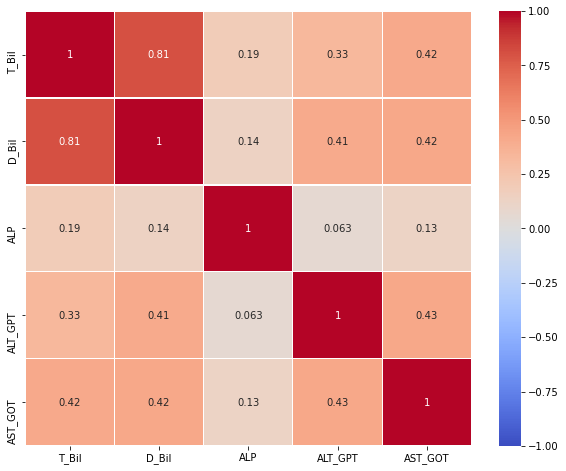

In [13]:
# seabornライブラリをsnsという省略名でインポート
import seaborn as sns
plt.figure(figsize=(10,8))
sns.heatmap(x_tmp.corr(), vmin=-1.0, vmax=1.0, annot=True, cmap='coolwarm', linewidths=0.1)
plt.show()

C:\Users\takasaki\Anaconda3\envs\matplotlib\lib\site-packages\seaborn\distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\takasaki\Anaconda3\envs\matplotlib\lib\site-packages\seaborn\distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)


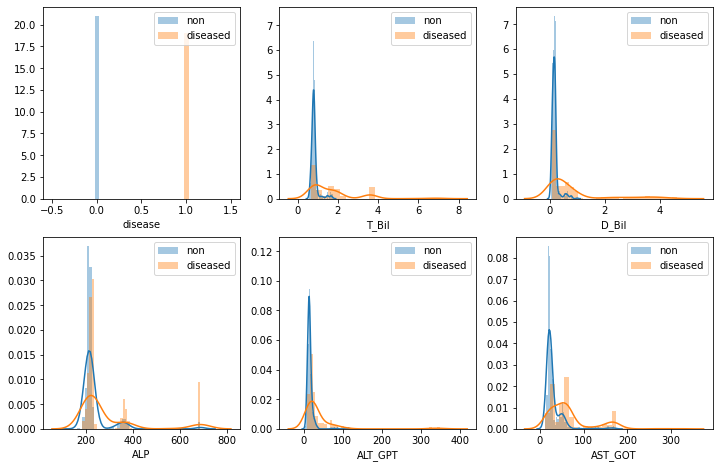

In [14]:

#グラフの表示
plt.figure(figsize=(12, 12))
# disease列とdf_numericを結合
df_csatt = pd.concat([df_train["disease"], x_tmp], axis=1)


for ncol, colname in enumerate(df_csatt.columns):
    plt.subplot(3, 3, ncol+1)
    sns.distplot(df_csatt.query("disease==0")[colname])
    sns.distplot(df_csatt.query("disease==1")[colname])
    plt.legend(labels=["non", "diseased"], loc='upper right')
plt.show()

In [15]:
x_tmp.describe()

,T_Bil,D_Bil,ALP,ALT_GPT,AST_GOT
count,850.000000,850.000000,850.000000,850.000000,850.000000
mean,1.212683,0.461926,259.404120,25.565119,46.009185
std,0.927980,0.785715,112.027572,36.870576,41.686726
min,0.585961,0.034861,163.261838,3.924518,11.283497
25%,0.781258,0.144889,213.991414,13.644658,21.239157
50%,0.835591,0.194085,220.092503,16.638001,27.056026
75%,1.196759,0.335447,229.455927,23.056081,56.461568
max,7.314605,4.614812,688.367780,370.984154,327.287931


In [16]:
print(x_tmp.shape)

(850, 5)


In [17]:
# 目的変数（訓練データ）
y_train = np.array(df_train.loc[:,['disease']])

# 組み込み法に使うモデルの指定
fs_model = LogisticRegression(penalty='l2', random_state=0)
# 閾値の指定
fs_threshold = "mean"
# 組み込み法モデルの初期化
selector = SelectFromModel(fs_model, threshold=fs_threshold)

# 特徴量生成
polynomial = PolynomialFeatures(degree=3, include_bias=False)
polynomial_arr = polynomial.fit_transform(np.array(x_tmp))
# polynomial_arrのデータフレーム化 （※カラムはshape[1]でpolynomial_arrの列数分だけ出力）
X_polynomial = pd.DataFrame(polynomial_arr, columns=["poly" + str(x_) for x_ in range(polynomial_arr.shape[1])])

# 特徴量選択の実行
selector.fit(X_polynomial, y_train)
mask = selector.get_support()

# 選択された特徴量だけのサンプル取得
X_polynomial_masked = X_polynomial.loc[:, mask]

x_train = np.array(X_polynomial_masked)




C:\Users\takasaki\Anaconda3\envs\matplotlib\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\takasaki\Anaconda3\envs\matplotlib\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [18]:
X_polynomial.describe()

,poly0,poly1,poly2,poly3,poly4,poly5,poly6,poly7,poly8,poly9,...,poly45,poly46,poly47,poly48,poly49,poly50,poly51,poly52,poly53,poly54
count,850.000000,850.000000,850.000000,850.000000,850.000000,850.000000,850.000000,850.000000,850.000000,850.000000,...,8.500000e+02,8.500000e+02,8.500000e+02,8.500000e+02,8.500000e+02,8.500000e+02,8.500000e+02,8.500000e+02,8.500000e+02,8.500000e+02
mean,1.212683,0.461926,259.404120,25.565119,46.009185,2.330735,1.150495,334.432229,42.289036,72.047173,...,3.141096e+07,2.234599e+06,4.139615e+06,5.521180e+05,4.897453e+05,1.054795e+06,4.668706e+05,2.186317e+05,2.338476e+05,5.155104e+05
std,0.927980,0.785715,112.027572,36.870576,41.686726,5.401551,3.219702,394.284485,124.317191,131.252607,...,7.019626e+07,6.304367e+06,7.702250e+06,3.679831e+06,1.407881e+06,2.420326e+06,4.118175e+06,1.751657e+06,1.254697e+06,1.973803e+06
min,0.585961,0.034861,163.261838,3.924518,11.283497,0.343350,0.023541,123.727799,2.677546,7.888472,...,4.351651e+06,2.028397e+05,4.722679e+05,3.501515e+03,1.848636e+04,2.931812e+04,6.044482e+01,5.711652e+02,9.058295e+02,1.436584e+03
25%,0.781258,0.144889,213.991414,13.644658,21.239157,0.610365,0.117172,169.889105,11.070056,16.990119,...,9.799164e+06,6.460827e+05,9.766780e+05,4.162272e+04,6.565971e+04,9.657725e+04,2.540318e+03,4.295678e+03,6.466057e+03,9.581023e+03
50%,0.835591,0.194085,220.092503,16.638001,27.056026,0.698213,0.161587,187.719480,14.424961,24.120383,...,1.066144e+07,8.450279e+05,1.387040e+06,6.552227e+04,1.240031e+05,1.735209e+05,4.605782e+03,9.533538e+03,1.419220e+04,1.980578e+04
75%,1.196759,0.335447,229.455927,23.056081,56.461568,1.432468,0.414427,354.161167,31.776001,56.950277,...,1.208086e+07,1.617172e+06,3.380981e+06,1.502131e+05,3.205345e+05,7.806760e+05,1.225627e+04,2.579833e+04,6.554528e+04,1.799961e+05
max,7.314605,4.614812,688.367780,370.984154,327.287931,53.503442,24.662079,4432.473174,1266.429516,1175.054459,...,3.261832e+08,1.573416e+08,8.388858e+07,7.589715e+07,2.218539e+07,2.539790e+07,5.105827e+07,3.120355e+07,2.796966e+07,3.505823e+07


In [19]:
X_polynomial_masked.describe()

,poly14,poly16,poly29,poly31,poly39,poly41,poly49,poly52,poly53
count,850.000000,850.000000,8.500000e+02,850.000000,8.500000e+02,850.000000,8.500000e+02,8.500000e+02,8.500000e+02
mean,79825.909547,12554.322787,1.137535e+05,20655.814441,4.716599e+04,9913.698350,4.897453e+05,2.186317e+05,2.338476e+05
std,96773.191047,13778.139014,2.563964e+05,46808.922046,1.570361e+05,29826.137385,1.407881e+06,1.751657e+06,1.254697e+06
min,26654.427668,2522.409939,2.381465e+04,1735.434310,1.366136e+03,134.714061,1.848636e+04,5.711652e+02,9.058295e+02
25%,45792.325274,4556.552215,3.630463e+04,3644.283159,7.184365e+03,795.730667,6.565971e+04,4.295678e+03,6.466057e+03
50%,48440.709901,6231.671434,4.126533e+04,6418.378499,9.694323e+03,1303.636392,1.240031e+05,9.533538e+03,1.419220e+04
75%,52650.022263,13840.099155,9.185716e+04,18201.556509,2.867047e+04,4548.178529,3.205345e+05,2.579833e+04,6.554528e+04
max,473850.200281,121865.934100,3.051172e+06,702946.859478,1.873105e+06,332132.469461,2.218539e+07,3.120355e+07,2.796966e+07


In [20]:
X_polynomial.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 850 entries, 0 to 849
Data columns (total 55 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   poly0   850 non-null    float64
 1   poly1   850 non-null    float64
 2   poly2   850 non-null    float64
 3   poly3   850 non-null    float64
 4   poly4   850 non-null    float64
 5   poly5   850 non-null    float64
 6   poly6   850 non-null    float64
 7   poly7   850 non-null    float64
 8   poly8   850 non-null    float64
 9   poly9   850 non-null    float64
 10  poly10  850 non-null    float64
 11  poly11  850 non-null    float64
 12  poly12  850 non-null    float64
 13  poly13  850 non-null    float64
 14  poly14  850 non-null    float64
 15  poly15  850 non-null    float64
 16  poly16  850 non-null    float64
 17  poly17  850 non-null    float64
 18  poly18  850 non-null    float64
 19  poly19  850 non-null    float64
 20  poly20  850 non-null    float64
 21  poly21  850 non-null    float64
 22  po

In [21]:
X_polynomial_masked.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 850 entries, 0 to 849
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   poly14  850 non-null    float64
 1   poly16  850 non-null    float64
 2   poly29  850 non-null    float64
 3   poly31  850 non-null    float64
 4   poly39  850 non-null    float64
 5   poly41  850 non-null    float64
 6   poly49  850 non-null    float64
 7   poly52  850 non-null    float64
 8   poly53  850 non-null    float64
dtypes: float64(9)
memory usage: 59.9 KB


#### 評価データのデータ加工前処理

In [22]:
# 説明変数（評価データ）
#x_tmp=df_vat
x_tmp=df_vat.loc[:,['T_Bil', 'D_Bil', 'ALP', 'ALT_GPT', 'AST_GOT']]

In [23]:
col='T_Bil'
std=sigma[col]*3
vat=df_desc.loc['75%',col]*3
#x_tmp.loc[x_tmp[col]>(std),col]=std
x_tmp.loc[x_tmp[col]>(std),col]=vat

col='D_Bil'
std=sigma[col]*3
vat=df_desc.loc['75%',col]*3
#x_tmp.loc[x_tmp[col]>(std),col]=std
x_tmp.loc[x_tmp[col]>(std),col]=vat

col='ALP'
std=sigma[col]*3
vat=df_desc.loc['75%',col]*3
#x_tmp.loc[x_tmp[col]>(std),col]=std
x_tmp.loc[x_tmp[col]>(std),col]=vat

col='ALT_GPT'
std=sigma[col]*3
vat=df_desc.loc['75%',col]*3
#x_tmp.loc[x_tmp[col]>(std),col]=std
x_tmp.loc[x_tmp[col]>(std),col]=vat

col='AST_GOT'
std=sigma[col]*3
vat=df_desc.loc['75%',col]*3
#x_tmp.loc[x_tmp[col]>(std),col]=std
x_tmp.loc[x_tmp[col]>(std),col]=vat


In [24]:

# 組み込み法に使うモデルの指定
fs_model = LogisticRegression(penalty='l2', random_state=0)
# 閾値の指定
fs_threshold = "mean"
# 組み込み法モデルの初期化
selector = SelectFromModel(fs_model, threshold=fs_threshold)

# 特徴量生成
polynomial = PolynomialFeatures(degree=3, include_bias=False)
polynomial_arr = polynomial.fit_transform(x_tmp)
# polynomial_arrのデータフレーム化 （※カラムはshape[1]でpolynomial_arrの列数分だけ出力）
X_polynomial = pd.DataFrame(polynomial_arr, columns=["poly" + str(x) for x in range(polynomial_arr.shape[1])])

# 選択された特徴量だけのサンプル取得
X_polynomial_masked = X_polynomial.loc[:, mask]

x_vat = np.array(X_polynomial_masked)


In [25]:
# yの変換
#y = np.zeros((len(y_train), 1 + y_train.max()), dtype=int)
#y[np.arange(len(y_train)), y_train.T] = 1
#y_train = y
# 分割
X_train,X_test,Y_train,Y_test=train_test_split(x_train, y_train, test_size=0.25, random_state=1) 

In [26]:
# 標準化
from sklearn.preprocessing import StandardScaler,MinMaxScaler
sc = StandardScaler() 
#norm = MinMaxScaler()
X_train=sc.fit_transform(X_train)
X_test=sc.transform(X_test)
X_vat=sc.transform(x_vat)

In [27]:
# numpy の値を torch の値に変換する
X_train = torch.from_numpy(X_train).float()
Y_train = torch.from_numpy(Y_train).float()
X_test = torch.from_numpy(X_test).float()
Y_test = torch.from_numpy(Y_test).float()
X_vat  = torch.from_numpy(X_vat).float()

In [28]:
# 行数、列数の確認
in_size=X_train.shape[1]
print(X_train.shape)
print(X_test.shape)


torch.Size([637, 9])
torch.Size([213, 9])


In [29]:
out_size=Y_train.shape[1]
Y_train.shape

torch.Size([637, 1])

In [30]:
print(X_vat.shape)


torch.Size([350, 9])


In [33]:
node1=60
node2=20


# Module を継承して、Netクラスを作成する
#  ノード数や階層を増やす　⇒　精度が向上する、学習のパフォーマンスは落ちる
#  ノード数や階層を減らす　⇒　精度が下がる、学習のパフォーマンスは上がる
#   　ノードや階層を変更しても精度が上がらない　⇒　入力データが不足している
class Net(nn.Module):
    # 初期化の関数
    def __init__(self):
        super(Net ,self).__init__()
        #   中間層のノード数は、精度向上やパフォーマンス向上を狙って調整する
        self.fc1 = nn.Linear(in_size , node1)         # nn.Linear (入力のノード数 , 中間層ノード数)
        self.fc2 = nn.Linear(node1 , node2)           # nn.Linear (中間層ノード数 , 中間層ノード数)
        self.fc3 = nn.Linear(node2,  out_size)        # nn.Linear (中間層ノード数 , 出力のノード数)
    
    # ネットワークを通して、出力値を求める関数
    def forward(self ,x):
        y = torch.sigmoid (self.fc1(x))               # 入力のノードを中間層（１階層目）に渡して結果を得る
        y = torch.sigmoid(self.fc2(y))               # 中間層（１階層目）を中間層（２階層目）に渡して結果を得る
        y = torch.sigmoid(self.fc3(y))              # 中間層（２階層目）の結果を出力層に渡す

        return y

In [34]:
# モデルの定義
model = Net()
# 損失の定義 (平均二乗誤差)
#criterion = nn.MSELoss()
# 損失の定義 (バイナリエントロピー誤差関数)
criterion = nn.BCELoss()
# 損失の定義 (交差エントロピー誤差関数)
#criterion = nn.CrossEntropyLoss()

In [35]:
# 最適化のアルゴリズムの選択　（Adam：Stochastic Gradient Descent）
## model.parameters  調整する値
## lr(learning rate) ：学習率　どれぐらいの幅でパラメータを更新していくのか
optimizer = optim.Adam(model.parameters() , lr=0.01)
#optimizer = optim.SGD(model.parameters() , lr=0.01)

In [36]:
loss_list = []
loss_temp = 0
logdisp=10


# トレーニングの回数分ループする。
for epoch in range(200):
    # 損失を初期化　
    total_loss = 0
    

    # 出力を計算する 
    output = model(X_train)
    # 損失の計算 (出力の結果；output と 正解：y_trainを渡す)
    loss = criterion(output ,Y_train)

    # パラメータの勾配を初期化する
    optimizer.zero_grad()
    # ロスを伝播する
    loss.backward()
    # パラメータを更新する
    optimizer.step()

    # トータルロスを格納
    loss_list.append(loss.item())
    
    # 10回毎に回数とトータルロスを表示する
    if (epoch+1)%logdisp == 0:
        print(f'Epoch {epoch+1} Loss {loss.item():4f}')
        

Epoch 10 Loss 0.647481
Epoch 20 Loss 0.545799
Epoch 30 Loss 0.480260
Epoch 40 Loss 0.464272
Epoch 50 Loss 0.449830
Epoch 60 Loss 0.432458
Epoch 70 Loss 0.419707
Epoch 80 Loss 0.410962
Epoch 90 Loss 0.405532
Epoch 100 Loss 0.403358
Epoch 110 Loss 0.401999
Epoch 120 Loss 0.400864
Epoch 130 Loss 0.399925
Epoch 140 Loss 0.399248
Epoch 150 Loss 0.398589
Epoch 160 Loss 0.397984
Epoch 170 Loss 0.397394
Epoch 180 Loss 0.396790
Epoch 190 Loss 0.396100
Epoch 200 Loss 0.395219


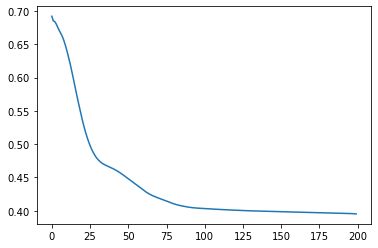

In [37]:
# ロスのプロット
plt.plot(loss_list)

## 誤差の確認

In [38]:
#print(Y_test)

In [44]:
# 学習を行わないモードに変更
model.eval()

# テストデータ

y_hat=model(x).data
y_hat=y_hat.round().numpy()
y_true=Y_test.numpy()
accuracy = np.sum(y_true == y_hat) /len(y_true)
print(accuracy)


0.8544600938967136


## ROC曲線の描画（偽陽性率、真陽性率、閾値の算出）

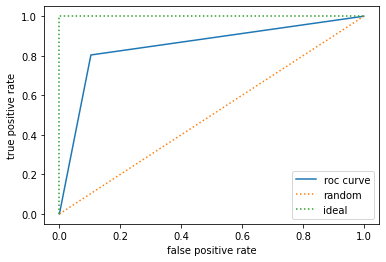

[2. 1. 0.]


In [45]:
# ROC曲線の描画（偽陽性率、真陽性率、閾値の算出）
fpr, tpr, thresholds = roc_curve(y_true=y_true, y_score=y_hat)
plt.plot(fpr, tpr, label='roc curve')
plt.plot([0, 1], [0, 1], linestyle=':', label='random')
plt.plot([0, 0, 1], [0, 1, 1], linestyle=':', label='ideal')
plt.legend()
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.show()
print(thresholds)

In [46]:
# AUCスコアの算出
auc_score = roc_auc_score(y_true=y_true, y_score=y_hat)
print("AUC:", auc_score)

AUC: 0.8503377177390686


#  予測する

In [42]:
y_predict = model(X_vat).data
print(y_predict)
y_predict = y_predict.round().numpy()
df_out = pd.DataFrame(np.array(y_predict ,dtype=np.int64), columns=['val'])

df_out.to_csv('./submit.csv', encoding='utf_8_sig' , header=False)


tensor([[0.1482],
        [0.1107],
        [0.1477],
        [0.1495],
        [0.1425],
        [0.1390],
        [0.9502],
        [0.7451],
        [0.2110],
        [0.1493],
        [0.2898],
        [0.0890],
        [0.1718],
        [0.9502],
        [0.1411],
        [0.0901],
        [0.8615],
        [0.1277],
        [0.1678],
        [0.1158],
        [0.7011],
        [0.1178],
        [0.1043],
        [0.5568],
        [0.1785],
        [0.1090],
        [0.1689],
        [0.9499],
        [0.1897],
        [0.9502],
        [0.3598],
        [0.9502],
        [0.1264],
        [0.2811],
        [0.9490],
        [0.9502],
        [0.1176],
        [0.1966],
        [0.1442],
        [0.9502],
        [0.5470],
        [0.7209],
        [0.8283],
        [0.1707],
        [0.4598],
        [0.5480],
        [0.1556],
        [0.9461],
        [0.1235],
        [0.2107],
        [0.3835],
        [0.7623],
        [0.9502],
        [0.3053],
        [0.7725],
        [0

# モデルの保存

In [43]:
#model_path = 'model.pth'
#torch.save(model.to('cpu').state_dict(), model_path)